In [1]:
import gzip
from collections import defaultdict
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
    
print "Reading data..."
data = list(readGz('train.json.gz'))
print "Done"

Reading data...
Done


In [75]:
# get user info and item info
user_info = defaultdict(set) # items bought
item_info = defaultdict(set) # categories
for d in data:
    u = d['reviewerID']
    i = d['itemID']
    user_info[u].add(i)
    for cate in d['categories']:
        for c in cate:
                item_info[i].add(c)

In [17]:
# get similarity between two items
def get_simi(i1,i2):
    # just use Jaccard similarity: J(A,B) = |A and B| / |A or B|
    a_and_b = 0
    a_or_b = 0
    for cate in item_info[i1]:
        if cate in item_info[i2]:
            a_and_b += 1
        else:
            a_or_b += 1
    a_or_b += len(item_info[i2])
    return a_and_b / (a_or_b * 1.0)

In [6]:
def add_all_item(s_i,i,u,user_info):
    for item in user_info[u]:
            s_i[i].add(item)
            


In [76]:
item_users = defaultdict(set)
for d in data:
    i = d['itemID']
    u = d['reviewerID']
    item_users[i].add(u)

In [77]:
similar_item = defaultdict(set)
for i in item_info:
    for u in item_users[i]:
        # add all items
        add_all_item(similar_item,i,u,user_info)


In [15]:
for i in similar_item:
    if i in similar_item[i]:
        similar_item[i].remove(i)

In [19]:
import time
t1 = time.ctime()
item_relation = defaultdict(set)
for i1 in item_info:
    for i2 in similar_item[i1]:
        item_relation[i1].add((i2,get_simi(i1,i2)))
t2 = time.ctime()
print str(t1)
print str(t2)

Sun Nov 18 08:22:15 2018
Sun Nov 18 08:22:19 2018


In [53]:
# input: user, item, item_relation, item_users, k
def will_purchase(u,i,i_r,i_u,k):
    if (u not in user_info) or (i not in item_info):
        return random.randint(0,1)
    # find k closet item, if they has been bought by u, i will bought by u
    friends = []
    for f in i_r[i]:
        friends.append(f)
    friends = sorted(friends, key=lambda x: x[1], reverse=True)
    index = 0
    if k > len(friends):
        k = len(friends)
    while index < k:
        item = friends[index][0]
        if u in i_u[item]:
            return 1
        index += 1
    return 0

In [39]:
# get test data
test_data = []
for i in range(1000):
    d = random.choice(data)
    test_data.append((d['reviewerID'],d['itemID']))

for i in range(1000):
    while 1:
        d1 = random.choice(data)
        d2 = random.choice(data)
        u = d1['reviewerID']
        i = d2['itemID']
        if u not in item_users[i]:
            test_data.append((u,i))
            break

    

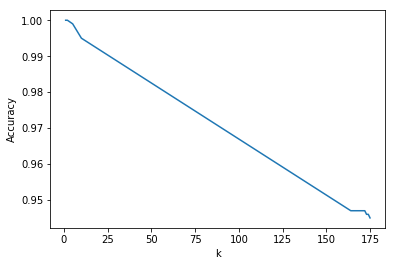

max acc:1.0
k: 1


In [63]:
# find the best k


klist = [1,2,5,10, 164, 166, 168, 169, 170, 171, 172, 173, 174, 175]
accs = []
for k in klist:
    acc = 0
    '''
    for d in test_data[:1000]:
        acc += will_purchase(d[0],d[1],item_relation,item_users,k)
    '''
    for d in test_data[1000:]:
        acc += (1-will_purchase(d[0],d[1],item_relation,item_users,k))
       
    acc /= (1000 * 1.0)
    accs.append(acc)

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(klist, accs)
plt.show()
print "max acc:" + str(max(accs))
print "k: " + str(klist[accs.index(max(accs))])

In [78]:
# get user categories
user_cate = defaultdict(set)
for d in data:
    u = d['reviewerID']
    for cate in d['categories']:
        for c in cate:
                user_cate[u].add(c)

In [79]:
# check if same sex between item and user
def sex(u,i):
    if 'Men' in user_cate[u] and 'Men' in item_info[i]:
        return 1
    if 'Women' in user_cate[u] and 'Women' in item_info[i]:
        return 1
    return 0

In [80]:
# check the category
def cate(u,i):
    count = 0
    for c in item_info[i]:
        if c in user_cate[u]:
            count += 1
    if count >= 5 or count >= len(item_info[i]):
        return 1
    return 0

In [81]:
# check gloable rank
businessCount = defaultdict(int)
totalPurchases = 0

for l in readGz("train.json.gz"):
  user,business = l['reviewerID'],l['itemID']
  businessCount[business] += 1
  totalPurchases += 1

mostPopular = [(businessCount[x], x) for x in businessCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalPurchases*.57: break

In [82]:
# similarity between u and i
def get_similarity(u, i, u_i):
    if i in u_i[u]:
        return 1
    # just use Jaccard similarity: J(A,B) = |A and B| / |A or B|
    all_cate = list()
    for item in u_i[u]:
        for cate_list in item_info[item]:
            for c in cate_list:
                if c not in all_cate:
                    all_cate.append(c)
    i_cate = list()
    for cate in item_info[i]:
        i_cate.append(cate)
    a_and_b = 0
    a_or_b = 0
    for c in i_cate:
        if c in all_cate:
            a_and_b += 1
        else:
            a_or_b += 1
    a_or_b += len(all_cate)
    return a_and_b / (a_or_b * 1.0)

In [83]:
# get the prediction
predictions = open("/Users/nan/Desktop/assign1_pairs_Purchase.txt", 'w')
for l in open("pairs_Purchase.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    
    res = 0
    '''
    if will_purchase(u,i,item_relation,item_users,171) > 0:
        res += .5
    '''
    if u in user_cate and i in item_info:
        res += get_similarity(u,i,user_info)
        if i in return1:
            res += .1
        else:
            res -= .1
        if cate(u,i) > 0:
            res += .3
        else:
            res -= .2
        if sex(u,i) > 0:
            res += .1
        else:
            res -= .5

        if res >= .5:
            res = 1
        else:
            res = 0
    else:
        res = random.randint(0,1)
        
    predictions.write(u + '-' + i + ',' + str(res) + '\n')
predictions.close()

In [56]:
sorted(item_relation['I006212764'], key=lambda x: x[1], reverse=True)

[('I909815747', 0.5),
 ('I375792318', 0.42857142857142855),
 ('I663327406', 0.42857142857142855),
 ('I684267425', 0.4),
 ('I913119235', 0.4),
 ('I069977672', 0.375),
 ('I768292795', 0.375),
 ('I736974828', 0.3333333333333333),
 ('I367609494', 0.3333333333333333),
 ('I033615058', 0.3333333333333333),
 ('I393698627', 0.25),
 ('I142463721', 0.25),
 ('I278591795', 0.25),
 ('I735204666', 0.2222222222222222),
 ('I096552695', 0.18181818181818182),
 ('I115027523', 0.16666666666666666),
 ('I673073190', 0.16666666666666666),
 ('I838544963', 0.15384615384615385),
 ('I606848644', 0.15384615384615385),
 ('I749722765', 0.14285714285714285),
 ('I379937308', 0.13333333333333333),
 ('I746527657', 0.13333333333333333)]

In [67]:
len(item_info)

19914

In [68]:
n = 0
for i in item_info:
    n += len(item_info[i])
n

136258

In [69]:
n / 19914

6

In [84]:
simi_user = defaultdict(set)
for i in item_users:
    for u in user_info:
        if u in item_users[i]:
            for uu in item_users[i]:
                if not uu == u:
                    simi_user[u].add(uu)

In [85]:
user_relation = defaultdict(set)
for u in simi_user:
    for uu in simi_user[u]:
        res = len(simi_user[u] & simi_user[uu])*1.0 / (len(simi_user[u]) + len(simi_user[uu]))
        user_relation[u].add((uu,res))
    

In [89]:
# by similar user
def pred_by_user(u,i,u_r,u_i,k):
    if (u not in user_info) or (i not in item_info):
        return random.randint(0,1)
    # find k closet user, if they has been bought by u, i will bought by u
    friends = []
    for f in u_r[u]:
        friends.append(f)
    friends = sorted(friends, key=lambda x: x[1], reverse=True)
    index = 0
    if k > len(friends):
        k = len(friends)
    while index < k:
        item = friends[index][0]
        if i in u_i[item]:
            return 1
        index += 1
    return 0

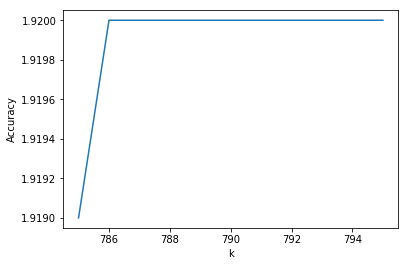

max acc:1.92
k: 786


In [100]:
# find the best k


klist = [785,786,787,788,789,790,791,792,793,794,795]
accs = []
for k in klist:
    acc = 0
    
    for d in test_data[:1000]:
        acc += pred_by_user(d[0],d[1],user_relation,user_info,k)
    
    for d in test_data[1000:]:
        acc += (1-pred_by_user(d[0],d[1],user_relation,user_info,k))
       
    acc /= (1000 * 1.0)
    accs.append(acc)

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(klist, accs)
plt.show()
print "max acc:" + str(max(accs))
print "k: " + str(klist[accs.index(max(accs))])

In [102]:
# get the prediction
predictions = open("/Users/nan/Desktop/assign1_pairs_Purchase.txt", 'w')
for l in open("pairs_Purchase.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    
    res = 0
    
    if u in user_cate and i in item_info:
        res = pred_by_user(u,i,user_relation,user_info,786) * will_purchase(u,i,item_relation,item_users,171)
    else:
        res = random.randint(0,1)
        
    predictions.write(u + '-' + i + ',' + str(res) + '\n')
predictions.close()

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
sklearn.metrics.pairwise.cosine_similarity([1,2,3],[3,2,1])

ValueError: Expected 2D array, got 1D array instead:
array=[1. 2. 3.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [4]:
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
import nltk
import string
from nltk.stem.porter import *
from sklearn import linear_model

def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)

### Just the first 5000 reviews

print "Reading data..."
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))[:5]
print "done"


Reading data...
done


In [20]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data[:1]:
    l = []
    for c in d['review/text'].lower(): 
        if c in punctuation: 
            l.append(' '+c) 
        else: 
            l.append(c)
  r = ''.join(l)
  print r
  for w in r.split():
    #w = stemmer.stem(w) # with stemming
    wordCount[w] += 1

a lot of foam . but a lot .	in the smell some banana , and then lactic and tart . not a good start .	quite dark orange in color , with a lively carbonation  (now visible , under the foam ) .	again tending to lactic sourness .	same for the taste . with some yeast and banana .


In [16]:
punctuation

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}